In [69]:

import jax
import jax.numpy as jnp
import optax
from jax.tree_util import Partial

jax.config.update("jax_enable_x64", True)


def RBFKernel(sigma_f, length, x, y):
    return (sigma_f * jnp.exp(-(jnp.linalg.norm(x - y) ** 2) / (2 * length ** 2))).astype(float)


def ExpSineSquaredKernel(sigma_f: float, length: float, periodictiy: float, x, y):
    def euclidian(x, y):
        return jnp.sqrt(jnp.maximum(jnp.sum((x - y) ** 2), 1e-36))

    return (
            sigma_f
            * jnp.exp(-2 * (jnp.sin(jnp.pi * euclidian(x, y) / periodictiy) / length) ** 2)
    ).astype(float)


# Helper function to calculate the respective covariance matrices
@jax.jit
def cov_matrix(x1, x2, cov_function):
    return jax.vmap(lambda x_: jax.vmap(lambda y_: cov_function(x_, y_))(x1))(x2)


#@jax.jit
def log_likelihood(kernel_, params, data_x, data_y):
    K = cov_matrix(data_x, data_x, Partial(kernel_, *params))
    K = K.at[jnp.diag_indices_from(K)].add(1e-10)
    L = jax.lax.linalg.cholesky(K)

    alpha = jax.scipy.linalg.cho_solve((L, True), data_y)

    return -(
            -0.5 * jnp.dot(data_y, alpha)
            - (jnp.log(jnp.diag(L))).sum()
            - 0.5 * K.shape[0] * jnp.log(2 * jnp.pi)
    )


class GPR:
    def __init__(self, data_x, data_y, kernel_, params):
        self.data_x = data_x
        self.data_y = data_y
        self.kernel_ = kernel_
        self.covariance_function = Partial(kernel_, *params)  #??
        self.params = params
        self.eps = 1e-10

        # Store the inverse of covariance matrix of input (+ machine epsilon on diagonal) since it is needed for every prediction
        self._inverse_of_covariance_matrix_of_input = self.inv_cov()

    # function to predict output at new input values. Store the mean and covariance matrix in memory.
    def predict(self, at_values, return_std=False):
        k_lower_left = cov_matrix(self.data_x, at_values, self.covariance_function)
        k_lower_right = cov_matrix(at_values, at_values, self.covariance_function)

        # Mean.
        mean_at_values = jnp.dot(
            k_lower_left, jnp.dot(self.data_y, self._inverse_of_covariance_matrix_of_input.T).T
        ).flatten()

        # Covariance.
        cov_at_values = k_lower_right - jnp.dot(
            k_lower_left, jnp.dot(self._inverse_of_covariance_matrix_of_input, k_lower_left.T)
        )

        # Adding value larger than machine epsilon to ensure positive semi definite
        cov_at_values = cov_at_values + 1e-10 * jnp.ones(jnp.shape(cov_at_values)[0])

        var_at_values = jnp.diag(cov_at_values)

        if return_std:
            return mean_at_values, jnp.sqrt(var_at_values)
        return mean_at_values

    def get_log_likelihood(self):
        return log_likelihood(self.kernel_, self.params, self.data_x, self.data_y)

    def inv_cov(self):
        return jnp.linalg.inv(
            cov_matrix(self.data_x, self.data_x, self.covariance_function)
            + 1e-10 * jnp.identity(len(self.data_x))
        )

    def fit(self):
        def get_update_fn(optimizer):
            def update(params, opt_state):
                grads = jax.grad(Partial(log_likelihood, self.kernel_))(params, self.data_x, self.data_y)  # ?
                updates, opt_state = optimizer.update(grads, opt_state, params=params)
                params = optax.apply_updates(params, updates)
                return params, opt_state

            return jax.jit(update)

        schedule = optax.warmup_cosine_decay_schedule(init_value=1e-2, decay_steps=1000, warmup_steps=100,
                                                      peak_value=1e-3, end_value=1e-3)

        optimizer = optax.chain(
            optax.clip(1),
            optax.sgd(learning_rate=3e-3),
            optax.clip(1),
        )

        params = self.params
        opt_state = optimizer.init(params)
        update_f = get_update_fn(optimizer)

        for j in range(1000):
            params, opt_state = update_f(params, opt_state)
            if j % 100 == 0:
                print(f"{j:} mll {log_likelihood(self.kernel_, params, self.data_x, self.data_y)} at {params}")

        self.params = params
        self.covariance_function = Partial(self.kernel_, *params)
        self._inverse_of_covariance_matrix_of_input = self.inv_cov()

    def fit2(self):
        import jaxopt
        solver = jaxopt.ScipyMinimize(fun=Partial(log_likelihood, self.kernel_))
        soln = solver.run(self.params, data_x=self.data_x, data_y=self.data_y)

        params, state = soln
        print(f"Final solve: {state.fun_val} at {params}")

        self.params = params
        self.covariance_function = Partial(self.kernel_, *params)
        self._inverse_of_covariance_matrix_of_input = self.inv_cov()

### Using Tree data

In [ ]:
import pandas as pd
from sklearn import gaussian_process
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

dendro = pd.read_feather("data/17766_12.feather")
dendro.dendroNr = (
    dendro[["dendroNr", "year"]].astype(str).agg("_".join, axis=1)
)  # Merge tree and year
dendro

In [ ]:
from sklearn.gaussian_process.kernels import RBF

tree_models = [
    gaussian_process.GaussianProcessRegressor(
        0.5 ** 2 * RBF(100, (1e-3, 1e8)), n_restarts_optimizer=1
    )
    for _ in range(3)
]

X = np.array(range(183)).reshape(-1, 1)

for i, tree_model in enumerate(tree_models):
    filt = dendro[
        dendro.species.eq(pd.unique(dendro.species)[i]) & dendro.DOY.mod(30).eq(0)
        ]  # Filter to prevent overfitting to data mean
    tree_model.fit(filt.DOY.array.reshape(-1, 1), filt.growth - filt.growth.mean())
    print(tree_model.kernel_)

In [ ]:
fig = plt.figure(figsize=(16, 9))
sns.set_theme(style="whitegrid", palette="pastel")

# All lines
sns.lineplot(
    data=dendro,
    x="DOY",
    y="growth",
    style="species",
    units="dendroNr",
    lw=0.8,
    estimator=None,
    c="lightgray",
    alpha=0.5,
)

plt.gca().set(xlim=(0, 182))

# Plot means
sns.lineplot(
    data=dendro,
    x="DOY",
    y="growth",
    hue="species",
    # estimator=None,
    # errorbar=('ci', 99),
    errorbar=None,
    lw=1,
    zorder=2,
    alpha=0.8,
)

X_test = np.linspace(0, 182, 300, True)
# Plot GP
for i, tree_model in enumerate(tree_models):
    filt = dendro[dendro.species.eq(pd.unique(dendro.species)[i]) & dendro.DOY.mod(30).eq(0)]
    sns.lineplot(
        x=X_test,
        y=tree_model.predict(X_test.reshape(-1, 1)).ravel() + filt.growth.mean(),
        lw=4,
        zorder=3,
        color=sns.color_palette()[i if i == 0 else [2, 1][i - 1]],
    )

plt.show()

## Compare
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared

X_true = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y_true = np.squeeze(X_true * np.cos(X_true))

rng = np.random.RandomState(2)
training_indices = rng.choice(np.arange(y_true.size), size=10, replace=False)
X_train, y_train = X_true[training_indices], y_true[training_indices]

# RBF parameters
s = 10
l = 0.1
p = 50

16.2**2 * ExpSineSquared(length_scale=0.000329, periodicity=5.07e+04)
-6.457248308869737
---
Final solve: 6.457316245687386 at [2.61872084e+02 2.81452941e-03 5.91371830e+03]
Partial(<function <lambda> at 0x7fef3d212700>, Array(261.87208405, dtype=float64), Array(0.00281453, dtype=float64), Array(5913.71829705, dtype=float64))
6.457316245687386


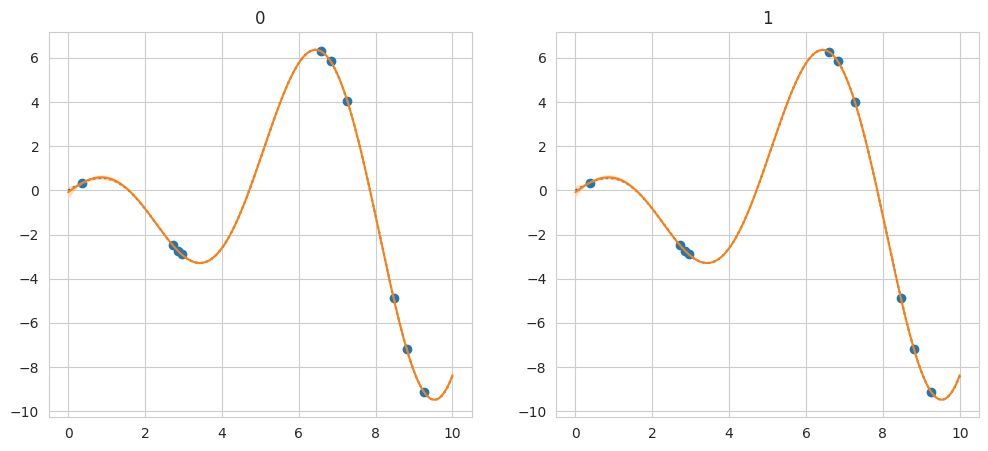

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, ax in enumerate(axs.flatten()):
    if i == 0:
        kernel = s * ExpSineSquared(l, p)
        gaussian_process = GaussianProcessRegressor(
            kernel=kernel, alpha=1e-10, n_restarts_optimizer=0
        )
        gaussian_process.fit(X_train, y_train)
        print(gaussian_process.kernel_)
        print(gaussian_process.log_marginal_likelihood_value_)

        print('---')
    else:
        kernel = lambda s, l, p, x, y: ExpSineSquaredKernel(s, l, p, x, y)
        gaussian_process = GPR(X_train, y_train, kernel, jnp.array([s, l, p], dtype=float))
        K = cov_matrix(gaussian_process.data_x, gaussian_process.data_x,
                       Partial(gaussian_process.kernel_, *gaussian_process.params))

        gaussian_process.fit2()
        print(gaussian_process.covariance_function)
        print(gaussian_process.get_log_likelihood())

    mean_prediction, std_prediction = gaussian_process.predict(X_true, return_std=True)
    ax.plot(X_true, y_true, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
    ax.scatter(X_train, y_train, label="Observations")
    ax.plot(X_true, mean_prediction, label="Mean prediction")
    ax.fill_between(
        X_true.ravel(),
        mean_prediction - 1.96 * std_prediction,
        mean_prediction + 1.96 * std_prediction,
        alpha=0.3,
    )
    ax.set_title(i)
plt.show()